In [1]:
!git clone https://github.com/facebookresearch/sam2.git

Cloning into 'sam2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 128.11 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (381/381), done.


In [2]:
import os
os.rename("sam2", "sam2_repo")


In [3]:
!shopt -s dotglob  # Include hidden files
!mv sam2_repo/* ./      # Move everything from sam2 to current directory
!rm -r sam2_repo        # Remove the now-empty sam2 folder (optional)

In [4]:
!pip install -e ".[notebooks]"

Obtaining file:///content
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
  

In [5]:
!pip install hydra-core

In [6]:
!cd checkpoints && ./download_ckpts.sh

--2025-08-01 04:26:32--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.102, 108.157.254.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M   419MB/s    in 0.4s    

2025-08-01 04:26:33 (419 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2025-08-01 04:26:33--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.102, 108.157.254.15, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1844

In [12]:
import os
os.chdir("/content")  # or wherever your configs/ folder is

In [32]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image
import numpy as np

checkpoint = "./checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    image = Image.open("/content/test.jpg").convert("RGB")
    predictor.set_image(image)
    # Define one foreground point (X, Y)
    point_coords = np.array([[1000, 1000]])         # shape: (1, 2)
    point_labels = np.array([1])                  # 1 = foreground, 0 = background

    # Run prediction
    masks, scores, logits = predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels,
        multimask_output=True
    )

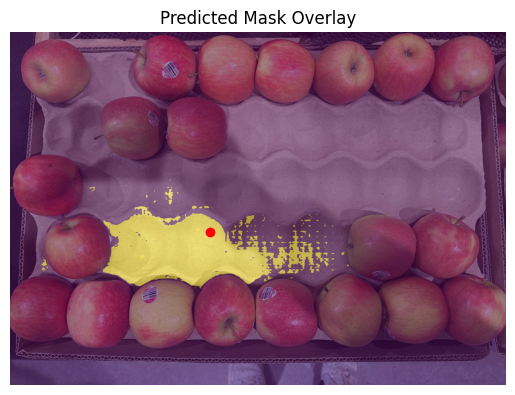

In [33]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.imshow(masks[0], alpha=0.5)  # Show first predicted mask overlay
plt.scatter(point_coords[:, 0], point_coords[:, 1], c='red')  # Show clicked point
plt.title("Predicted Mask Overlay")
plt.axis('off')
plt.show()

In [37]:
import numpy as np
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Step 1: Load image (as NumPy array in HWC format)
image = np.array(Image.open("/content/test.jpg").convert("RGB"))

# Step 2: Load model
model = build_sam2("configs/sam2.1/sam2.1_hiera_l", "checkpoints/sam2.1_hiera_large.pt")

# Step 3: Initialize automatic mask generator
mask_generator = SAM2AutomaticMaskGenerator(
    model,
    points_per_side=64,                 # increase sampling resolution
    pred_iou_thresh=0.7,                # allow slightly lower quality masks
    stability_score_thresh=0.85,        # allow more masks
    min_mask_region_area=100            # allow smaller regions
)


# Step 4: Generate masks for entire image
masks = mask_generator.generate(image)


/content/sam2/sam2_image_predictor.py:431: UserWarning: /content/sam2/_C.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


/content/sam2/sam2_image_predictor.py:431: UserWarning: /content/sam2/_C.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


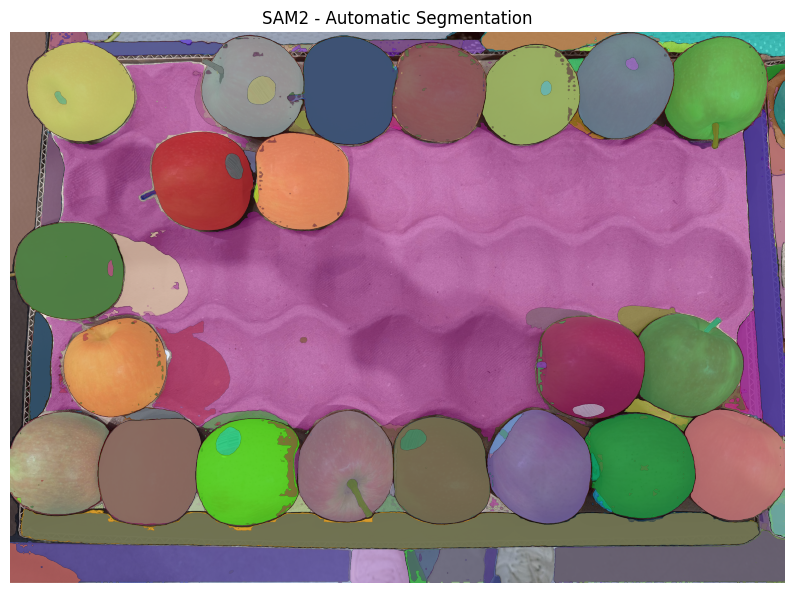

In [7]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

# Step 1: Load image as NumPy array in HWC format
image = np.array(Image.open("/content/test.jpg").convert("RGB"))

# Step 2: Load SAM2 model
model = build_sam2(
    "configs/sam2.1/sam2.1_hiera_l",
    "checkpoints/sam2.1_hiera_large.pt"
)

# Step 3: Initialize automatic mask generator with tuned parameters
mask_generator = SAM2AutomaticMaskGenerator(
    model,
    points_per_side=64,                # higher = better detail
    pred_iou_thresh=0.7,               # allow more masks
    stability_score_thresh=0.85,       # allow more masks
    min_mask_region_area=100           # ignore tiny noise
)

# Step 4: Generate masks
masks = mask_generator.generate(image)

# Step 5: Visualize masks with random colors
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("SAM2 - Automatic Segmentation")

# Overlay each mask with a unique random color
for ann in masks:
    color = np.concatenate([np.random.random(3), [0.5]])  # RGBA with transparency
    mask = ann["segmentation"]
    plt.imshow(np.stack([mask]*4, axis=-1) * color)

plt.axis("off")
plt.show()
